In [1]:
import numpy as np
import b18_routines as b18
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math

In [2]:
verbose = 1

%config Completer.use_jedi = False  #Speeds up tab autocomplete in notebooks

# Badro et al 2016, Figure 1b

The equations are 

$$ log K_{Mg} = 1.23 - \frac{18816}{T} $$ 
$$ K_{Mg} = \frac{X_{Mg}^2}{X_{MgO}}$$

Hence

$$ 2 log X_{mg} = 1.23 + log X_{MgO} - \frac{18816}{T} $$

Since $X_{MgO} = 0.5$, $log X_{MgO} = -0.3$ we have

$$ X_{mg} = 10^{0.46 - 9408/T} .$$

The cell below reproduces Fig 1b. 


# Fischer

Gives us Kd for O and Si. These agree with their Fig 6. Note that to see the agreement for O requires evaluating ay 100GPa rather than 135 GPa. 

In [3]:
def Mg_exchange(XMgO, XFe, XFeO, KMg, loggammaO, loggammaMg):
    """B18 eqn 10
        
        Returns the molar concentration of Mg in the metal based on an exchange reaction
    """
    return 10**( np.log10(KMg) + np.log10(XFe*XMgO) - np.log10(XFeO) - loggammaO - loggammaMg)



def Mg_dissolution(XMgO, KMg, loggammaO, loggammaMg):
    """B18 eqn 9
        
        Returns the molar concentration of MgO in the metal based on a dissolution reaction
    """
    return 10**( np.log10(KMg) + np.log10(XMgO) - loggammaO - loggammaMg)



def Mg_dissolution_B16(XMgO,KMg):
    """B16 eqn 4
    
        Returns the molar concentratino of Mg in the metal based on a dissolution reaction
    """
    return 10**( (np.log10(KMg) + np.log10(XMgO))/2.0 )



def Mg_dissociation(XMgO, XO, KMg, loggammaO, loggammaMg):
    """B18 eqn 8
    
        Returns the molar concentration of Mg in the metal based on a dissociation reaction
    """
    return 10**( np.log(XMgO) + np.log(KMg) - np.log(XO) - loggammaO - loggammaMg)

In [4]:
# Set up input parameters that will be fixed throughout
a, b, c = 0.1  ,-14054, 0.0 # Dissociation   #TABLE S2 of B18
a, b, c = -1.98, -4402, 0.0 # Exchange

#2 sets of values for dissolution from '16 and '18 papers
a_Mg_B16, b_Mg_B16, c_Mg_B16 = 1.23, -18816.0, 0.0
a_Mg_B18, b_Mg_B18, c_Mg_B18 = 1.06  ,-12842, 0.0 # Dissolution - use this for now. 

a_Mg_OS, b_Mg_OS, c_Mg_OS = 0.1,-10851,0.0
a_Si_OS, b_Si_OS, c_Si_OS = 1.3,-13500,0.0  # Fischer
a_O_OS , b_O_OS , c_O_OS  = 0.6,-3800 ,22.0 # Fischer 2015

# From the paper
eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0,-17.1, 3.6, 9.0, 4.9

# From JBs spreadsheet
eps_OO , eps_SiSi, eps_CC, eps_SS , eps_MgMg        = -1.0, 12.4, 12.8,-5.7, 0.0
eps_OSi, eps_OC  , eps_OS, eps_CSi, eps_SSi, eps_SC = -5.0,-20.0, -7.4, 9.7, 9.0, 6.1
eps_CMg, eps_OMg , eps_SiMg, eps_SMg                = 0.0, -21.6, 4.6, 0.0

In [5]:
# These params may want to change...
Tcmb   = np.linspace(6000,2000,101)

core_mass_fractions = [0.03, 0.03, 0]
XO_c, XSi_c, XMgO_c = b18.mass2moleconc_core(*core_mass_fractions) #Mass fractions of core O,Si,MgO in mole fractions

XS_c = 0.0000
XC_c = 0.0000
XFe_c= 1-XO_c-XSi_c-XMgO_c
XMgO_m = 0.5

print('\nMass fractions in the core')
display(Math(r'c_O^{{metal}} = {}\\ c_{{Si}}^{{metal}} = {}\\ c_{{MgO}}^{{metal}} = {}\\ c_{{Fe}}^{{metal}} = {}'.format(*core_mass_fractions,1-np.sum(core_mass_fractions))))

print('\n\nMole fractions in the core')
display(Math(r'X_O^{{metal}} = {}\\ X_{{Si}}^{{metal}} = {}\\ X_{{MgO}}^{{metal}} = {}\\ X_{{FeO}}^{{metal}} = {}'.format(XO_c, XSi_c, XMgO_c, XFe_c)))

print('\n\nMole fractions in the mantle')
display(Math(r'X_{{MgO}}^{{silicate}} = {}'.format(XMgO_m)))

#Check mole fractions sum to 1
assert np.sum([XO_c, XSi_c, XMgO_c, XFe_c]) == 1, 'Mole fractions in the core do not sum up to 1'


Mass fractions in the core


<IPython.core.display.Math object>



Mole fractions in the core


<IPython.core.display.Math object>



Mole fractions in the mantle


<IPython.core.display.Math object>

## Calculate activity coefficients ($\gamma$)

In [6]:
cO_c_ni, cSi_c_ni, cMg_c_ni = np.zeros(len(Tcmb)), np.zeros(len(Tcmb)), np.zeros(len(Tcmb))
loggammaO, loggammaMg       = np.zeros(len(Tcmb)), np.zeros(len(Tcmb))

# eps needs to be a YxY symmetric matrix containing coeffs for C, O, Si, S, Mg, ...,. 
X_C   = np.array( [XC_c   , XO_c   , XSi_c   , XS_c   , XMgO_c])
eps_C = np.array([[eps_CC , eps_OC , eps_CSi , eps_SC , eps_CMg], 
                  [eps_OC , eps_OO , eps_OSi , eps_OS , eps_OMg], 
                  [eps_CSi, eps_OSi, eps_SiSi, eps_SSi, eps_SiMg],
                  [eps_SC , eps_OS , eps_SSi , eps_SS , eps_SMg],
                  [eps_CMg, eps_OMg, eps_SiMg, eps_SMg, eps_MgMg]])

print('Input mole fractions [C, O, Si, S]: \n', X_C)
print('Input eps matrix: \n', eps_C)

lngamma0a = np.array([-0.62,     4.29, -6.65, 0.0, 0.0])
lngamma0b = np.array([-0.00, -16500.0, 0.00 , 0.0, 0.0])

T0 = 1873.0
verb = 0

tt = 0
for t in Tcmb: 
    eps = eps_C * T0 / t                                             # eqn S6
    lngamma0   = lngamma0a + lngamma0b/t
    lngamma0   = lngamma0  * (T0 / t)                                # eqn S5
    lngamma0[1]= lngamma0[1] * t/T0                                  # Do not set 
    lngammaFe  = b18.ln_gamma_Fe(X_C,eps,verb)                       # eqn S3
    lngammai   = b18.ln_gamma_i( X_C,eps, lngammaFe, lngamma0, verb) # eqn S4
    
    print(lngamma0)
    if verbose == 1:
        print('T = {:6.1f} gammaC0 = {:6.4f} gamma_O0 = {:6.4f} gammaSi0 = {:6.4f} gammaS0 = {:6.4f} gammaMg0 = {:6.4f}'
              .format(t,np.exp(lngamma0[0]),np.exp(lngamma0[1]),np.exp(lngamma0[2]), np.exp(lngamma0[3]), np.exp(lngamma0[4])))
        print('T = {:6.1f} gammaC  = {:6.4f} gamma_O  = {:6.4f} gammaSi  = {:6.4f} gammaS  = {:6.4f} gammaMg  = {:6.4f} gammaFe  = {:5.3f}'
          .format(t,np.exp(lngammai[0]),np.exp(lngammai[1]),np.exp(lngammai[2]), np.exp(lngammai[3]),np.exp(lngammai[4]), np.exp(lngammaFe)))

    loggammaO[tt]  = lngammai[1]/2.303
    loggammaMg[tt] = lngammai[4]/2.303
        
    tt = tt + 1

Input mole fractions [C, O, Si, S]: 
 [0.         0.09502262 0.05429864 0.         0.        ]
Input eps matrix: 
 [[ 12.8 -20.    9.7   6.1   0. ]
 [-20.   -1.   -5.   -7.4 -21.6]
 [  9.7  -5.   12.4   9.    4.6]
 [  6.1  -7.4   9.   -5.7   0. ]
 [  0.  -21.6   4.6   0.    0. ]]
[-0.19354333  1.54       -2.07590833  0.          0.        ]
T = 6000.0 gammaC0 = 0.8240 gamma_O0 = 4.6646 gammaSi0 = 0.1254 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 6000.0 gammaC  = 0.8282 gamma_O  = 4.1259 gammaSi  = 0.1326 gammaS  = 1.0050 gammaMg  = 1.0050 gammaFe  = 1.005
[-0.19484228  1.52154362 -2.0898406   0.          0.        ]
T = 5960.0 gammaC0 = 0.8230 gamma_O0 = 4.5793 gammaSi0 = 0.1237 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 5960.0 gammaC  = 0.8271 gamma_O  = 4.0471 gammaSi  = 0.1309 gammaS  = 1.0051 gammaMg  = 1.0051 gammaFe  = 1.005
[-0.19615878  1.50283784 -2.10396115  0.          0.        ]
T = 5920.0 gammaC0 = 0.8219 gamma_O0 = 4.4944 gammaSi0 = 0.1220 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 

[-0.25244783  0.70304348 -2.70770652  0.          0.        ]
T = 4600.0 gammaC0 = 0.7769 gamma_O0 = 2.0199 gammaSi0 = 0.0667 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4600.0 gammaC  = 0.7820 gamma_O  = 1.7211 gammaSi  = 0.0717 gammaS  = 1.0066 gammaMg  = 1.0066 gammaFe  = 1.007
[-0.25466228  0.67157895 -2.73145833  0.          0.        ]
T = 4560.0 gammaC0 = 0.7752 gamma_O0 = 1.9573 gammaSi0 = 0.0651 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4560.0 gammaC  = 0.7803 gamma_O  = 1.6655 gammaSi  = 0.0701 gammaS  = 1.0066 gammaMg  = 1.0066 gammaFe  = 1.007
[-0.25691593  0.63955752 -2.75563053  0.          0.        ]
T = 4520.0 gammaC0 = 0.7734 gamma_O0 = 1.8956 gammaSi0 = 0.0636 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4520.0 gammaC  = 0.7786 gamma_O  = 1.6107 gammaSi  = 0.0685 gammaS  = 1.0067 gammaMg  = 1.0067 gammaFe  = 1.007
[-0.25920982  0.60696429 -2.78023438  0.          0.        ]
T = 4480.0 gammaC0 = 0.7717 gamma_O0 = 1.8349 gammaSi0 = 0.0620 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 4480

T = 2960.0 gammaC  = 0.6824 gamma_O  = 0.2159 gammaSi  = 0.0167 gammaS  = 1.0102 gammaMg  = 1.0102 gammaFe  = 1.010
[-0.39769178 -1.36068493 -4.26556507  0.          0.        ]
T = 2920.0 gammaC0 = 0.6719 gamma_O0 = 0.2565 gammaSi0 = 0.0140 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2920.0 gammaC  = 0.6788 gamma_O  = 0.1993 gammaSi  = 0.0158 gammaS  = 1.0104 gammaMg  = 1.0104 gammaFe  = 1.010
[-0.40321528 -1.43916667 -4.32480903  0.          0.        ]
T = 2880.0 gammaC0 = 0.6682 gamma_O0 = 0.2371 gammaSi0 = 0.0132 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2880.0 gammaC  = 0.6752 gamma_O  = 0.1836 gammaSi  = 0.0149 gammaS  = 1.0105 gammaMg  = 1.0105 gammaFe  = 1.011
[-0.40889437 -1.51985915 -4.38572183  0.          0.        ]
T = 2840.0 gammaC0 = 0.6644 gamma_O0 = 0.2187 gammaSi0 = 0.0125 gammaS0 = 1.0000 gammaMg0 = 1.0000
T = 2840.0 gammaC  = 0.6715 gamma_O  = 0.1688 gammaSi  = 0.0140 gammaS  = 1.0107 gammaMg  = 1.0107 gammaFe  = 1.011
[-0.41473571 -1.60285714 -4.448375    0.          0. 

In [7]:
# Compare logKd values form different studies
logKd_MgO_B16 = b18.logKd_ideal(a_Mg_B16, b_Mg_B16, c_Mg_B16, Tcmb)
logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Tcmb)
logKd_MgO_O16 = b18.logKd_ideal(a_Mg_OS , b_Mg_OS , c_Mg_OS , Tcmb)

logKd_O       = b18.logKd_ideal(a_O_OS , b_O_OS , c_O_OS , Tcmb) #From Fischer and used in Mittal & O16
logKd_Si      = b18.logKd_ideal(a_Si_OS, b_Si_OS, c_Si_OS, Tcmb) #From Fischer and used in Mittal & O16

Kd_O  = 10**logKd_O #From Fischer and used in Mittal
Kd_Si = 10**logKd_Si
Kd_Mg = 10**logKd_MgO_O16

XFeO_m  = 10**( np.log10(XFe_c*XO_c)   - logKd_O )
XSiO2_m = 10**( np.log10(XSi_c*XFeO_m) - np.log10(XFe_c) - logKd_Si )

In [23]:
def min_conc_closure():

    params = {}

    def min_conc(XMg, XO, XSi, XMgO_m, eps_C, lngamma0, logKd_MgO_B18, T):
            
        XO_tot = XO + XMg
        X_C    = np.array( [0.0 , XO_tot, XSi  , 0.0   , XMg] )

        T0   = 1873.0
        verb = 0
    
        eps = eps_C * T0 / T                                             # eqn S6
        lngammaFe  = b18.ln_gamma_Fe(X_C,eps,verb)                       # eqn S3
        lngammai   = b18.ln_gamma_i( X_C,eps, lngammaFe, lngamma0, verb) # eqn S4
    
        print('X = ',X_C)
    
        loggammaO  = lngammai[1]/2.303
        loggammaMg = lngammai[4]/2.303

        XMg_ni  = Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,loggammaMg)
        # JBs eqn - gives same ans
        #XMg_ni2 = np.exp ( logKd_MgO_B18*2.303 + np.log(XMgO_m) - lngammai[1] - lngammai[4] );
        
        print('T = {:6.1f} gammaC  = {:6.4f} gamma_O  = {:6.4f} gammaSi  = {:6.4f} gammaS  = {:6.4f} gammaMg  = {:6.4f} gammaFe  = {:5.3f}'
          .format(T,np.exp(lngammai[0]),np.exp(lngammai[1]),np.exp(lngammai[2]), np.exp(lngammai[3]),np.exp(lngammai[4]), np.exp(lngammaFe)))
        
        params['lngamma']   = lngammai
        params['lngammaFe'] = lngammaFe
        params['X']         = np.array( [0.0   , XO_tot   , XSi   , 0.0   , XMg_ni] )
        print(XMg_ni, XMg)
        print('***')

        return XMg_ni - XMg
    
    return params, min_conc

params, min_conc = min_conc_closure()

T0    = 1873.0
Ttest = 4100.0   
XO    = 0.095
XSi   = 0.054

logKd_MgO_B18 = b18.logKd_ideal(a_Mg_B18, b_Mg_B18, c_Mg_B18, Ttest)

lngamma0a = np.array([-0.62,     4.29, -6.65, 0.0, 0.0])
lngamma0b = np.array([-0.00, -16500.0, 0.00 , 0.0, 0.0])    # eqn S6
lng0   = lngamma0a + lngamma0b/Ttest
lng0   = lng0    * (T0 / Ttest)                             # eqn S5
lng0[1]= lng0[1] * Ttest/T0                                 # Do not set O

#optimize.brentq(min_conc, 0.0, 0.6, args=(XO, XSi, XMgO_m, eps_C, lng0, logKd_MgO_B18, Ttest))
#print(params['X'])
#print('END OPT')

min_conc(0.03, XO, XSi, XMgO_m, eps_C, lng0, logKd_MgO_B18, Ttest)
print(params['X'])

X =  [0.    0.125 0.054 0.    0.03 ]
T = 4100.0 gammaC  = 0.7951 gamma_O  = 0.7937 gammaSi  = 0.0536 gammaS  = 1.0555 gammaMg  = 0.3052 gammaFe  = 1.055
0.017478249026156037 0.03
***
[0.         0.125      0.054      0.         0.01747825]


ValueError: x and y must have same first dimension, but have shapes (101,) and (1,)

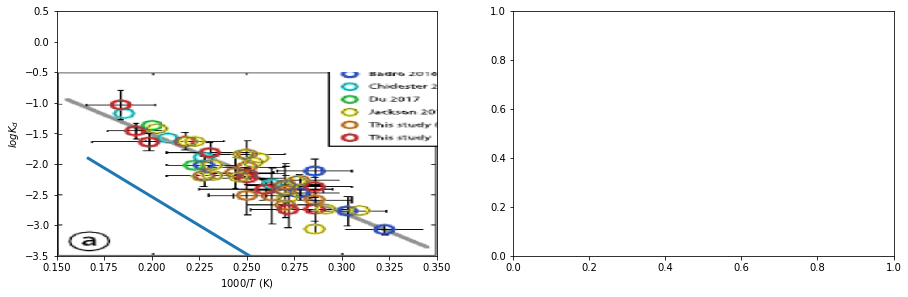

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,4.5))

fischer_a = plt.imread('Fischer_2016_fig6a.png')
fischer_b = plt.imread('Fischer_2016_fig6b.png')
#ax1.imshow(fischer_a, extent=(0.15,0.55,-5,2), aspect='auto') #Plot fischer plot below

badro_1a = plt.imread('badro_18_fig1a.png')
ax1.imshow(badro_1a, extent=(0.15,0.35,-3.5,-0.5), aspect='auto')

ax1.set_ylim([-3.5,0.5]) # Fischer Fig 6
ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$log K_d$")
ax1.set_xlim([0.15,0.35])
ax1.plot(1000.0/Tcmb, logKd_MgO_B16, lw=3, label="Badro et al (2016)")
ax1.plot(1000.0/Tcmb, logKd_MgO_B18, lw=3, label="Badro et al (2018)")
ax1.plot(1000.0/Tcmb, logKd_MgO_O16, lw=3, label="OS16")
ax1.plot(1000.0/Tcmb, logKd_Si,      lw=3, label="Si")
ax1.legend()

ax2.imshow(fischer_b, extent=(0.15,0.55,-5,2), aspect='auto')
#ax2.set_ylim([-5,2]) # Fischer Fig 6
ax2.set_xlabel("$1000/T$ (K)")
ax2.set_ylabel("$log K_d$")
ax2.plot(1000.0/Tcmb, logKd_O, lw=3, label="O (P=135)")
ax2.plot(1000/Tcmb, b18.logKd_ideal(a_O_OS , b_O_OS , c_O_OS , Tcmb, P=100), lw=3, label='O (P=100)')
ax2.plot(1000/Tcmb, b18.logKd_ideal(a_O_OS , b_O_OS , c_O_OS , Tcmb, P=0),   lw=3, label='O (P=0)')
ax2.legend()
plt.show()

Note that Figure 6 plots from Fischer 2016 are plotted in the background above

In [ ]:
# Find the eq conc at each T for just MgO equilibrium
XMg_B16_E  = Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_B16, 0.0, 0.0)  #NO LAMDAS?
XMg_B18_E  = Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_E  = Mg_exchange(XMgO_m, XFe_c, XFeO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_E, cSi_c_B16_E, cMg_c_B16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_E)
cO_c_B18_E, cSi_c_B18_E, cMg_c_B18_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_E)
cO_c_O16_E, cSi_c_O16_E, cMg_c_O16_E = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_E)

XMg_B16_DC = Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_B16 , 0.0, 0.0)
XMg_B18_DC = Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_B18 , 0.0, 0.0)
XMg_O16_DC = Mg_dissociation(XMgO_m, XO_c, 10**logKd_MgO_O16, 0.0, 0.0)

XMg_B16_DL = Mg_dissolution(XMgO_m, 10**logKd_MgO_B16, 0.0, 0.0)
XMg_B18_DL = Mg_dissolution(XMgO_m, 10**logKd_MgO_B18, 0.0, 0.0)
XMg_O16_DL = Mg_dissolution(XMgO_m, 10**logKd_MgO_O16, 0.0, 0.0)
cO_c_B16_DL, cSi_c_B16_DL, cMg_c_B16_DL = b18.mole2massconc_core(XO_c, XSi_c, XMg_B16_DL)
cO_c_B18_DL, cSi_c_B18_DL, cMg_c_B18_DL = b18.mole2massconc_core(XO_c, XSi_c, XMg_B18_DL)
cO_c_O16_DL, cSi_c_O16_DL, cMg_c_O16_DL = b18.mole2massconc_core(XO_c, XSi_c, XMg_O16_DL)


#DONT NEED TO ADD O

XMg_B18_DLni  = Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,loggammaMg)
XO_c_ni       = XMg_B18_DLni + XO_c                                         # Add O in MgO to core O 

#not sure about this step ^
cO_c_B18_DLni, cSi_c_B18_DLni, cMg_c_B18_DLni = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLni)


XMg_B18_DLni2 = Mg_dissolution(XMgO_m, 10**logKd_MgO_B18,loggammaO,0.0)
XO_c_ni      =  XMg_B18_DLni2 + XO_c                                         # Add O in MgO to core O 

#Or this one ^
cO_c_B18_DLni2, cSi_c_B18_DLni2, cMg_c_B18_DLni2 = b18.mole2massconc_core(XO_c_ni, XSi_c, XMg_B18_DLni2)

# Making sure we can reproduce B16 Fig 1b
XMg_B16_3 = Mg_dissolution_B16(XMgO_m, 10**logKd_MgO_B16)
cO_c_B16_3, cSi_c_B16_3, cMg_c_B16_3 = b18.mole2massconc_core(0.0, 0.0, XMg_B16_3)


print('Tcmb        = ', Tcmb[0])
print('\nInput mole fractions:')
display(Math(r'X_O^{{metal}} = {}\\ X_{{Si}}^{{metal}} = {}\\ X_{{MgO}}^{{metal}} = {}\\ X_{{FeO}}^{{metal}} = {}'.format(XO_c, XSi_c, XMgO_c, XFe_c)))

display(Math(r'X_{{MgO}}^{{silicate}} = {}\\'.format(XMgO_m)))
#print('Input mole fractions in the core: \n', X_C)
#print('XMgO_mantle = ', XMgO_m)
print('a + b/T     = ', logKd_MgO_B18[0])
print('log_gammaO  = ', loggammaO[0])
print('log_gammaMg = ', loggammaMg[0])
display(Math(r'X_{{MgO}}^{{metal}} = {}'.format(XMg_B18_DLni[0])))
#print('XMgO_core   = ', XMg_B18_DLni[0])
print('Which should be the same as:')
print(10**(a_Mg_B18 + b_Mg_B18/Tcmb[0] + np.log10(XMgO_m) - loggammaO[0] - loggammaMg[0]))

In [ ]:
fig, (ax2,ax3) = plt.subplots(1,2,figsize=(12,6))

badro_1b = plt.imread('badro_16_fig1b.png')
ax2.imshow(badro_1b, extent=(3000,7000,0,12), aspect='auto')

badro_4a = plt.imread('badro_18_fig4a.png')
ax2.imshow(badro_4a, extent=(4000,5000,0,1.5), aspect='auto')


ax2.set_title("Dissolution")
ax2.set_xlim([4000,5000])
ax2.set_ylim([0   ,3   ])
ax2.set_xlabel("$T$ (K)")
ax2.set_ylabel("$X_{Mg}^{core}$ (wt%)")
ax2.plot(Tcmb, cMg_c_B16_3*100    , label='B16', color="g", lw=3)
#ax2.plot(Tcmb, cMg_c_B16_DL*100   , label="B16" , color="blue")
ax2.plot(Tcmb, cMg_c_B18_DL*100   , label="B18 $\gamma_i=0$"         , color='red', lw=3)
ax2.plot(Tcmb, cMg_c_B18_DLni*100 , label="B18 $\gamma_O\\ne0 \gamma_{Mg}\\ne0$ ", color='red',linestyle='--', lw=3)
ax2.plot(Tcmb, cMg_c_B18_DLni2*100, label="B18 $\gamma_O\\ne0 \gamma_{Mg}=0$ " , color='red',linestyle=':', lw=3)
ax2.plot(Tcmb, cMg_c_O16_DL*100   , label="O16", color='orange', lw=3)
ax2.legend()

ax3.set_title("Exchange")
ax3.set_xlim([4000,5000])
ax3.set_ylim([0   ,30   ])
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$X_{Mg}^{core}$ (wt%)")
#ax3.plot(Tcmb, cMg_c_B16_E*100 , label="B16" , color="blue")
ax3.plot(Tcmb, cMg_c_B18_E*100 , label="B18" , color="red")
ax3.plot(Tcmb, cMg_c_O16_E*100, label="O16", color="orange")
ax3.legend()
plt.show()

Note that fig1b from Badro 2016 and fig 4a from Badro 2018 are plotted in the background

### Badro (2018) equation 11 (which is for dissolution)

$\rm{log}X_{MgO}^{core} = a + \frac{b}{T} + \rm{log}X_{MgO}^{mantle} - \rm{log}\gamma_{Mg}^{core} - \rm{log}\gamma_{O}^{core}$

In [ ]:
print('From the figure above, at Tcmb=4100 K, the weight % of Mg in the core should be 0.5\n')

loggammaO_4100 = np.interp(4100, Tcmb[::-1], loggammaO[::-1])
loggammaMg_4100 = np.interp(4100, Tcmb[::-1], loggammaMg[::-1])

print('a = {}, b = {}, T = {}'.format(a_Mg_B18, b_Mg_B18,4100))
display(Math('log(X_{{MgO}}^{{mantle}}) = {}'.format(np.log10(XMgO_m))))
display(Math('log(\gamma_{{Mg}}^{{core}}) = {}'.format(loggammaMg_4100)))
display(Math('log(\gamma_{{O}}^{{core}}) = {}'.format(loggammaO_4100)))

print('a + b/T = {}'.format(a_Mg_B18 + b_Mg_B18/4100))
print('Therefore:')
XMgO_4100 = 10**(a_Mg_B18 + b_Mg_B18/4100 + np.log10(XMgO_m) - loggammaMg_4100 - loggammaO_4100)

display(Math('X_{{MgO}}^{{core}} = {}'.format(XMgO_4100)))
print('\nConvert to mass fractions of O, Si, MgO in the core')

cO_4100, cSi_4100, cMgO_4100 = b18.mole2massconc_core(XO_c, XSi_c, XMgO_4100)
print('wt % of:\n O = {}\n Si = {}\n MgO = {}'.format(100*cO_4100, 100*cSi_4100, 100*cMgO_4100))


In [ ]:
print('From Badro et al. (2018), at Tcmb=4100 K, the weight % of Mg in the core should be 0.5\n')

loggammaO_4100 = np.interp(4100, Tcmb[::-1], loggammaO[::-1])
loggammaMg_4100 = np.interp(4100, Tcmb[::-1], loggammaMg[::-1])

print('a = {}, b = {}, T = {}'.format(a_Mg_B18, b_Mg_B18,4100))
print('log(X_MgO) = {}'.format(np.log10(XMgO_m)))
print('log(gamma_Mg = {}'.format(loggammaMg_4100))
print('log(gamma_O = {}'.format(loggammaO_4100))

print('a + b/T = {}'.format(a_Mg_B18 + b_Mg_B18/4100))
print('\nTherefore:')
XMgO_4100 = 10**(a_Mg_B18 + b_Mg_B18/4100 + np.log10(XMgO_m) - loggammaMg_4100 - loggammaO_4100)

print('X_MgO = {}'.format(XMgO_4100))
print('\nConvert to mass fraction of MgO in the core:')

cO_4100, cSi_4100, cMgO_4100 = b18.mole2massconc_core(XO_c, XSi_c, XMgO_4100)
print('MgO = {} wt%'.format(100*cMgO_4100))


print('\n\n\n\nIf we change b = {:.5f}, a reduction of 7%, then:\n'.format(0.93*b_Mg_B18))

print('a = {}, b = {}, T = {}'.format(a_Mg_B18, 0.93*b_Mg_B18,4100))
print('log(X_MgO) = {}'.format(np.log10(XMgO_m)))
print('log(gamma_Mg = {}'.format(loggammaMg_4100))
print('log(gamma_O = {}'.format(loggammaO_4100))

print('a + b/T = {}'.format(a_Mg_B18 + 0.93*b_Mg_B18/4100))
print('\nTherefore:')
XMgO_4100 = 10**(a_Mg_B18 + 0.93*b_Mg_B18/4100 + np.log10(XMgO_m) - loggammaMg_4100 - loggammaO_4100)

print('X_MgO = {}'.format(XMgO_4100))
print('\nConvert to mass fraction of MgO in the core:')

cO_4100, cSi_4100, cMgO_4100 = b18.mole2massconc_core(XO_c, XSi_c, XMgO_4100)
print('MgO = {} wt%'.format(100*cMgO_4100))

badro_4a = plt.imread('badro_18_fig4a.png')
plt.imshow(badro_4a, extent=(4000,5000,0,1.5), aspect='auto')
plt.title('Badro et al. (2018) Figure 4a')


XMgO_all_mod = 10**(a_Mg_B18 + 0.93*b_Mg_B18/Tcmb + np.log10(XMgO_m) - loggammaMg - loggammaO)
cMgO_all_mod = np.array([b18.mole2massconc_core(XO_c, XSi_c, X)[2] for X in XMgO_all_mod])

XMgO_all = 10**(a_Mg_B18 + b_Mg_B18/Tcmb + np.log10(XMgO_m) - loggammaMg - loggammaO)
cMgO_all = np.array([b18.mole2massconc_core(XO_c, XSi_c, X)[2] for X in XMgO_all])

plt.plot(Tcmb, 100*cMgO_all_mod, 'r', lw=3, label='b = {:.2f}'.format(0.93*b_Mg_B18))
plt.plot(Tcmb, 100*cMgO_all, 'k', lw=3, label='b = {:.2f}'.format(b_Mg_B18))
plt.xlim(4000,5000)
plt.ylim(0, 1.5)
plt.legend(loc=0)
plt.show()

## Badro et al (2018) SI 

In [ ]:
dT = Tcmb[1] - Tcmb[0]
dcMgdT = np.gradient(cMg_c_B18_DLni, dT)
plt.xlim([4000,5000])
plt.xlabel("$T$ (K)")
plt.ylabel("$dc_{MgO}/dT$ (K$^{-1}$)")
plt.plot(Tcmb, dcMgdT)